### Notebook for experimenting/debugging data reduction related stuff and doing data analysis

In [1]:
from data_reduction import DataSheet, xlsx_temp_series, xlsx_modulation, df_label_names
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.debugger import Tracer

In [2]:
# Define constants
NUM_SHEETS_MOD = 32
NUM_SHEETS_TEMP = 8

In [3]:
# Create a list of DataSheet objects for the flux bias current/modulation Excel sheet
mod_DataSheets = []
for j in range(NUM_SHEETS_MOD):
    mod_DataSheets.append(DataSheet(xlsx_modulation, 'modulation', sheet_num = j))
    
temp_DataSheets = []
for j in range(NUM_SHEETS_TEMP):
    temp_DataSheets.append(DataSheet(xlsx_temp_series, 'temperature series', sheet_num = j))

In [4]:
# Mean subtract
for sheet in mod_DataSheets:
    sheet.mean_subtract()

for sheet in temp_DataSheets:
    sheet.mean_subtract()

In [5]:
# Combine the three sets for each sheet
for sheet in mod_DataSheets:
    sheet.combine_sets()

for sheet in temp_DataSheets:
    sheet.combine_sets()

In [6]:
# Window Average to down sample
for sheet in mod_DataSheets:
    sheet.combined_set = sheet.window_avg(sheet.combined_set, n=10)

for sheet in temp_DataSheets:
    sheet.combined_set = sheet.window_avg(sheet.combined_set, n=10)

In [7]:
# An array, filled out by hand, that denotes the "kink" locations for the start and end of the super conducting regions
# in the IV plots for the modulation series. is a (32 x 3) dimensional array. First element of each row is the index 
# of the data sheet. Next two elements are the start/end of the superconducting region (in data units).
loc_array = np.array([[0, -0.5, 1.5], [1, -1.25, 2.25], [2, -2.5, 3.5], [3, -3.0, 4.0], [4, -3.0, 4.5], [5, -3.5, 4.0], 
                     [6, -4.0, 4.5], [7, -4.5, 5.0], [8, -4.5, 5.0], [9, -4.0, 4.5], [10, -4.0, 4.5], [11, -4.5, 4.5], 
                    [12, -4.0, 4.0], [13, -4.0, 4.0], [14, -4.0, 4.0], [15, -4.0, 3.0], [16, -4.0, 3.0], [17, -3.0, 3.0], 
                    [18, -3.5, 3.0], [19, -3.5, 3.0], [20, -2.5, 2], [21, -2.0, 2.0], [22, -2.5, 2.0], [23, -2.0, 1.5], 
                    [24, -2.0, 1.0], [25, -1.5, 0.5], [26, -1.0, 0.0], [27, -1.0, 0.0], [28, -1.0, 0.5], [29, -1.5, 0.5], 
                    [30, -2.0, 1.0], [31, -2.5, 1.0]])

In [8]:
def detrend_linear(data_set, sheet_num, loc_array):
    
    m_super, b_super = fit_super_conduct(data_set, loc_array[sheet_num, 1] + 0.5, loc_array[sheet_num, 2] - 0.5)
    
    chan_1, chan_2 = zip(*data_set)
    
    chan_1 = np.asarray(chan_1)
    chan_2 = np.asarray(chan_2)
    
    if sheet_num == 26 or sheet_num == 27:
        
        # Just trust us
        m_super = 0.00281282328861
        b_super = 0.00749494910652
    
    linear_trend = m_super * chan_1 + b_super
    
    chan_2 = chan_2 - linear_trend
    
    new_set = list(zip(chan_1, chan_2))
    
    return new_set, m_super, b_super

In [9]:
def fit_super_conduct(data_set, loc_1, loc_2):
    
    chan_1, chan_2 = zip(*data_set)
    
    chan_1 = np.asarray(chan_1)
    chan_2 = np.asarray(chan_2)
    
    index_1 = (np.abs(chan_1 - loc_1)).argmin()
    index_2 = (np.abs(chan_1 - loc_2)).argmin()
    
    m, b = np.polyfit(chan_1[index_1:index_2 + 1], chan_2[index_1:index_2 + 1], 1)
    
    return m, b

In [10]:
mod_no_linear_trend_list = []
for i,sheet in enumerate(mod_DataSheets):
    # Tracer()()
    mod_no_linear_trend_list.append(list(detrend_linear(sheet.combined_set, i, loc_array)))
print(len(mod_no_linear_trend_list))

32


/Users/josephmurphy/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:11: RankWarning: Polyfit may be poorly conditioned
/Users/josephmurphy/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:11: RankWarning: Polyfit may be poorly conditioned


Sheet index = 0


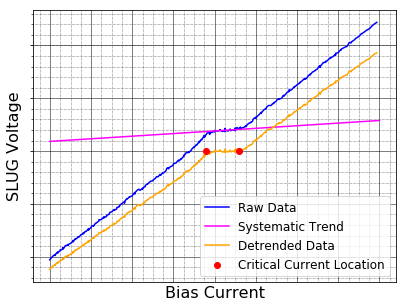

Sheet index = 1


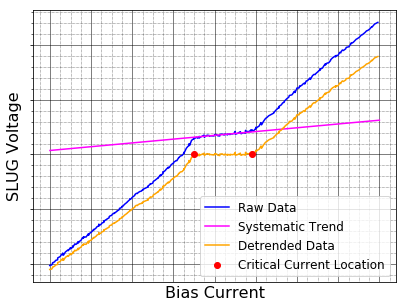

Sheet index = 2


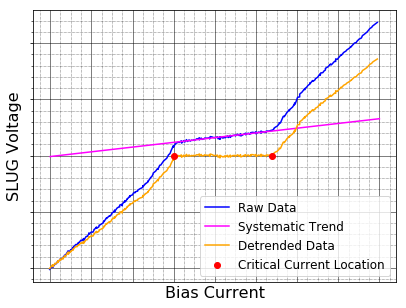

Sheet index = 3


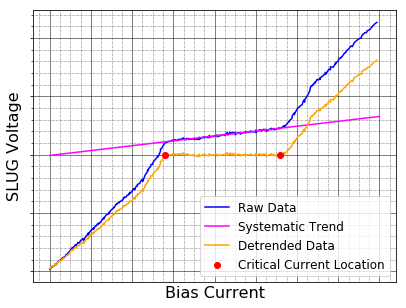

Sheet index = 4


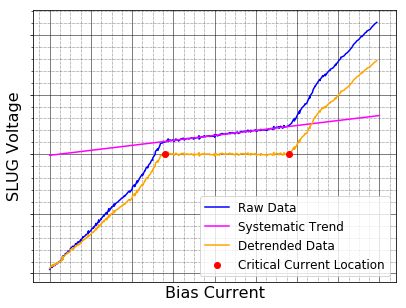

Sheet index = 5


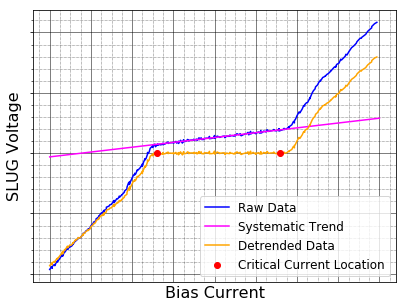

Sheet index = 6


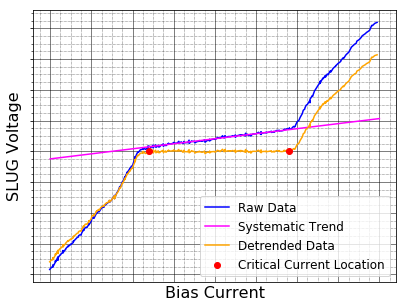

Sheet index = 7


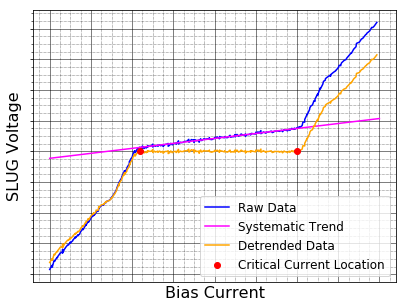

Sheet index = 8


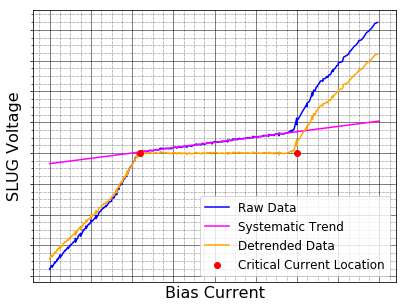

Sheet index = 9


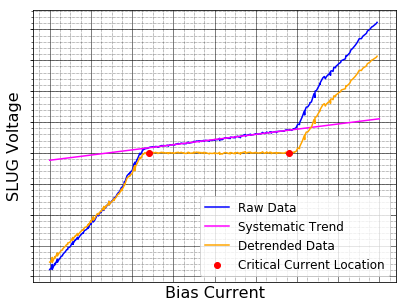

Sheet index = 10


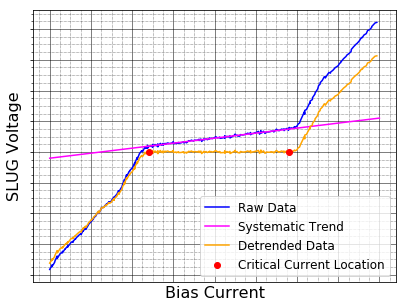

Sheet index = 11


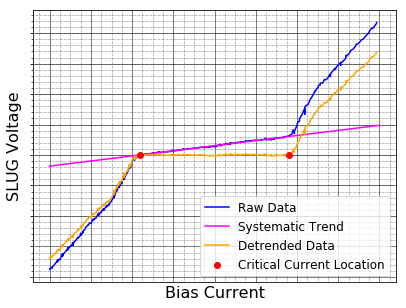

Sheet index = 12


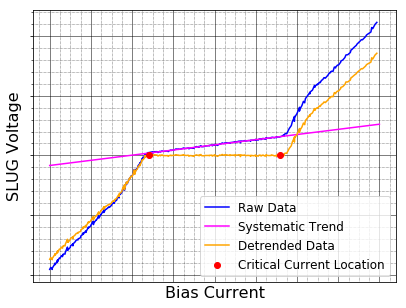

Sheet index = 13


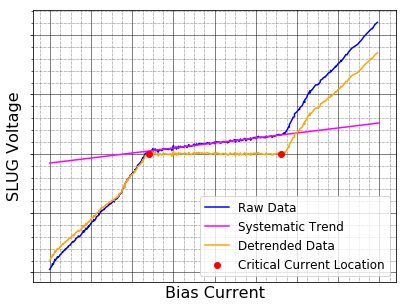

Sheet index = 14


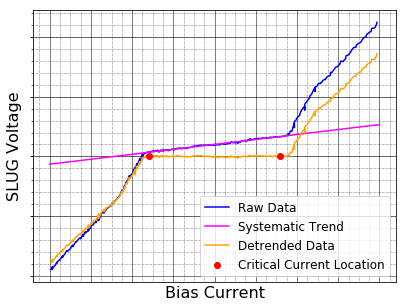

Sheet index = 15


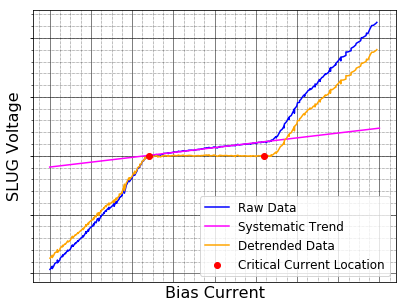

Sheet index = 16


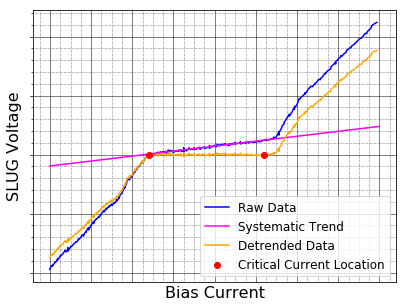

Sheet index = 17


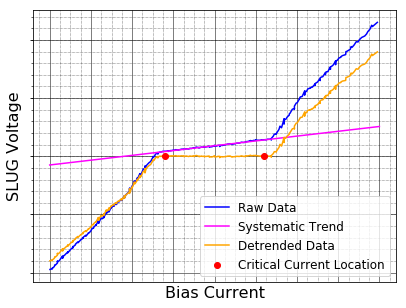

Sheet index = 18


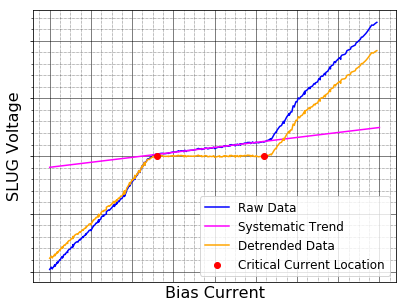

Sheet index = 19


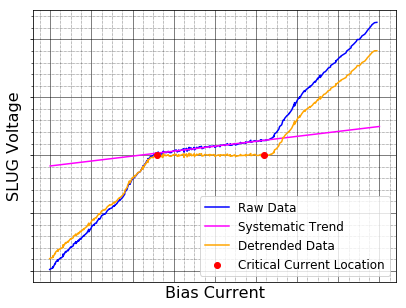

Sheet index = 20


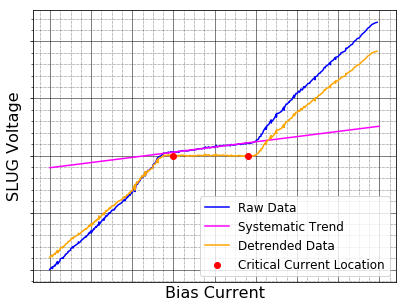

Sheet index = 21


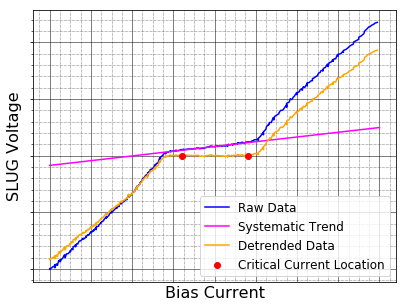

Sheet index = 22


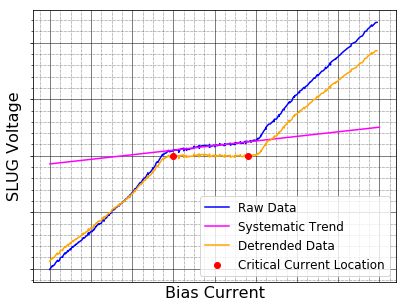

Sheet index = 23


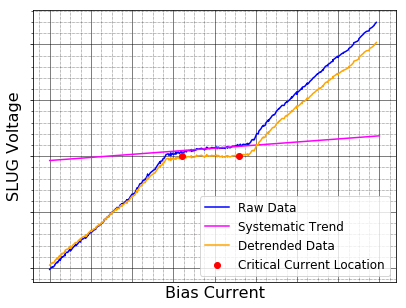

Sheet index = 24


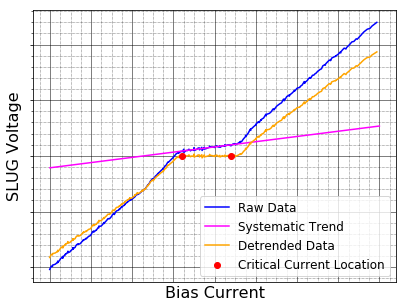

Sheet index = 25


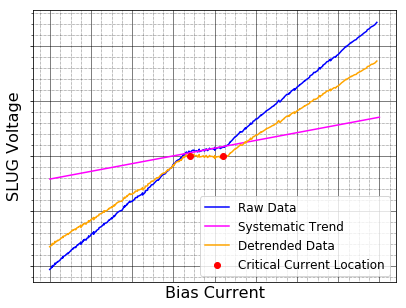

Sheet index = 26


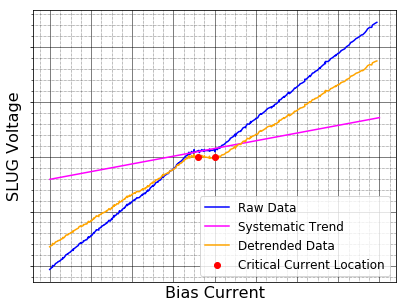

Sheet index = 27


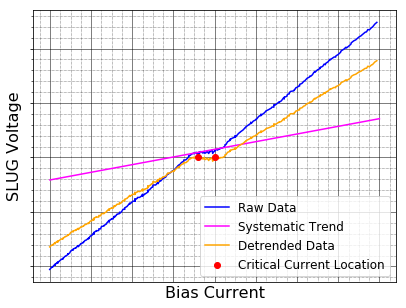

Sheet index = 28


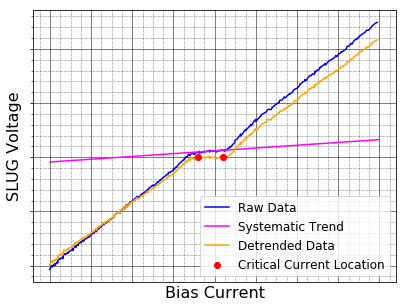

Sheet index = 29


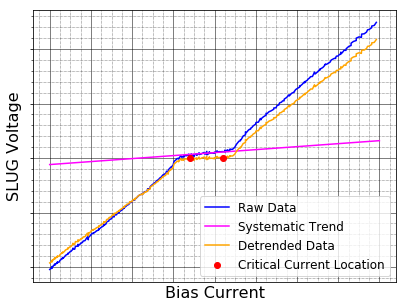

Sheet index = 30


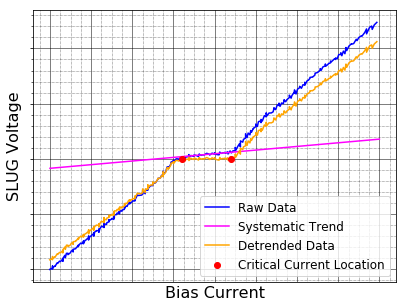

Sheet index = 31


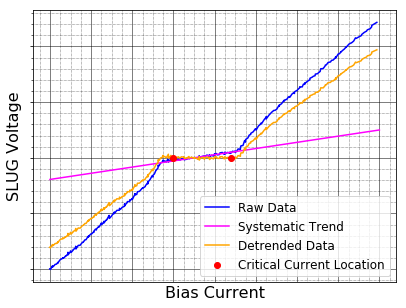

In [40]:
save_sheets = [0, 13, 19, 22]

m_super = []

i = 0

for sheet_idx,sheet in zip(range(len(mod_no_linear_trend_list)), mod_DataSheets):
    
    fig, ax = plt.subplots(figsize=(6.5, 5))
    print('Sheet index = {}'.format(sheet_idx))
    chan_1_no_lin, chan_2_no_lin = zip(*mod_no_linear_trend_list[sheet_idx][0])
    chan_1, chan_2 = zip(*mod_DataSheets[sheet_idx].combined_set)

    # Plot the original data
    ax.plot(chan_1, chan_2, color='blue', label='Raw Data')

    # Plot the linear fit to the superconducting region
    x = np.linspace(-10, 10, 300)
    
    m = mod_no_linear_trend_list[i][1]
    b = mod_no_linear_trend_list[i][2]
         
    # Add the slope of the superconducting region to the m_super list to plot for later
    gain = sheet.setup_params['srs gain']
    m_super.append((m / gain) * 1e4)
    
    ax.plot(x, m*x + b, color='magenta', label='Systematic Trend')

    # Plot the linear trend subtracted data
    ax.plot(chan_1_no_lin, chan_2_no_lin, color='orange', label='Detrended Data')

    # Plot the kink locations
    ax.scatter(loc_array[sheet_idx, 1], 0, color='red', zorder=100, label='Critical Current Location')
    ax.scatter(loc_array[sheet_idx, 2], 0, color='red', zorder=100)
    
    labels = [item.get_text() for item in ax.get_yticklabels()]
    empty_string_labels = ['']*len(labels)
    ax.set_yticklabels(empty_string_labels)
    
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off') # labels along the bottom edge are off
    
    ax.set_xlabel('Bias Current', fontsize=16)
    ax.set_ylabel('SLUG Voltage', fontsize=16)
    
    ax.legend(bbox_to_anchor=(1.0, 0.00), prop={'size':12}, loc=4, fancybox=True)
    
    ax.minorticks_on()

    # Customize the major grid
    ax.grid(which='major', linestyle='-', linewidth='0.5', color='black')
    # Customize the minor grid
    ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    
    if sheet_idx == 3:
        fig.savefig('final_figures/paper_figures/linear_detrend_figure.png', bbox_inches='tight', dpi=300)

    
    #if sheet_idx in save_sheets:
        #fig.savefig('final_figures/linear_detrend_{}.png'.format(str(sheet_idx).zfill(3)), bbox_inches='tight', dpi=300)
    
    # Show the plot
    
    i += 1
    plt.show()

Sheet index = 0
Sheet index = 1
Sheet index = 2
Sheet index = 3
Sheet index = 4
Sheet index = 5
Sheet index = 6
Sheet index = 7
Sheet index = 8
Sheet index = 9
Sheet index = 10
Sheet index = 11
Sheet index = 12
Sheet index = 13
Sheet index = 14
Sheet index = 15
Sheet index = 16
Sheet index = 17
Sheet index = 18
Sheet index = 19
Sheet index = 20


/Users/josephmurphy/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Sheet index = 21
Sheet index = 22
Sheet index = 23
Sheet index = 24
Sheet index = 25
Sheet index = 26
Sheet index = 27
Sheet index = 28
Sheet index = 29
Sheet index = 30
Sheet index = 31


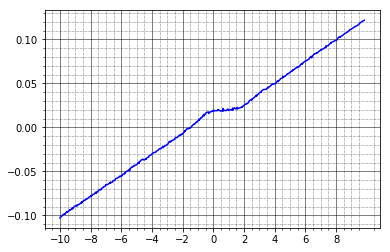

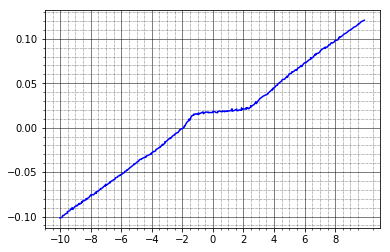

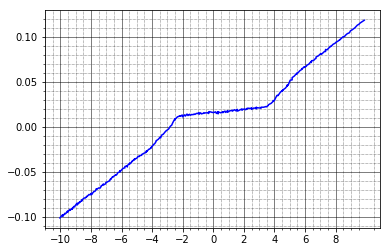

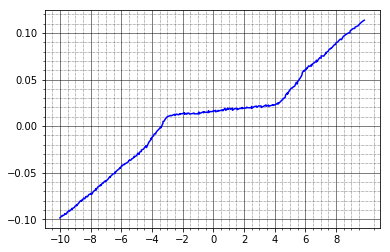

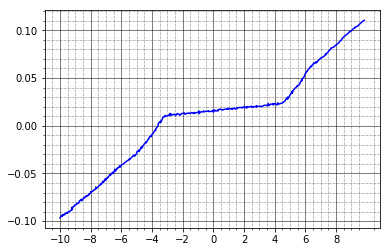

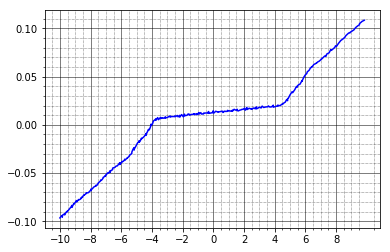

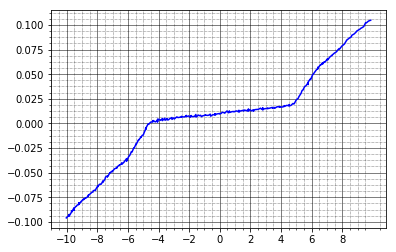

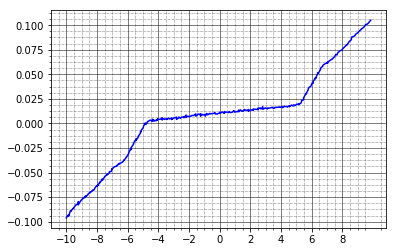

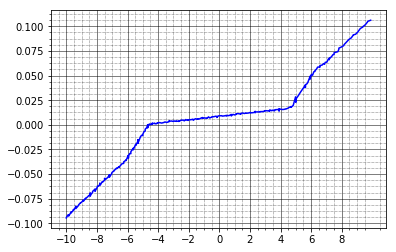

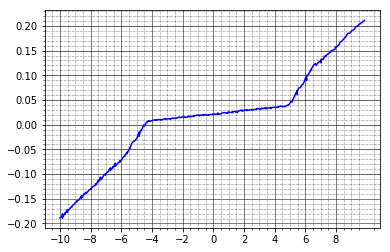

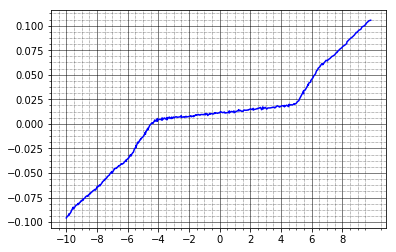

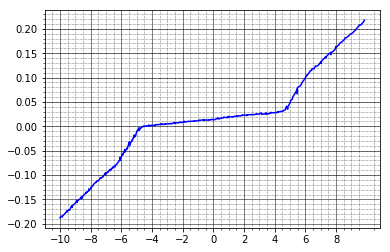

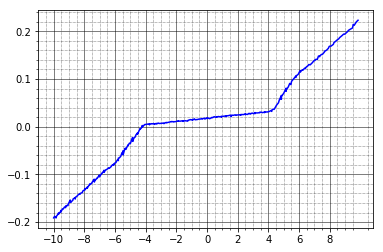

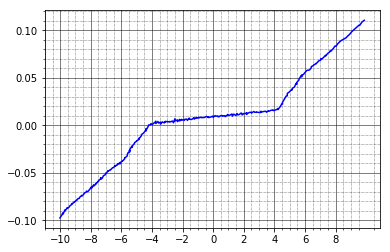

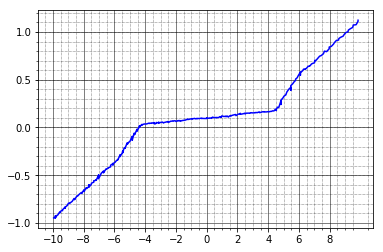

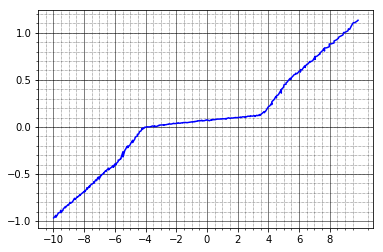

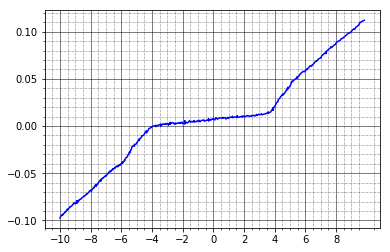

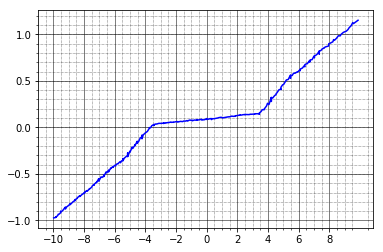

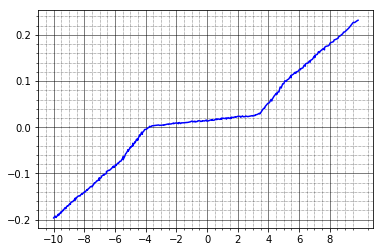

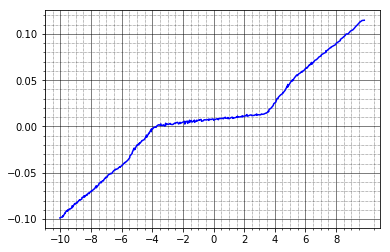

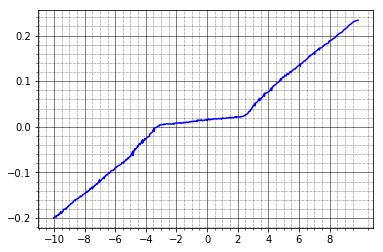

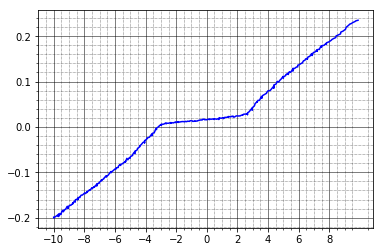

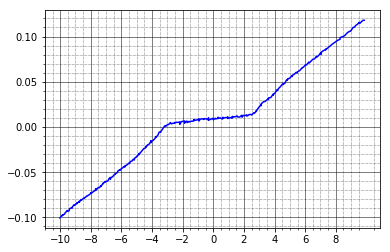

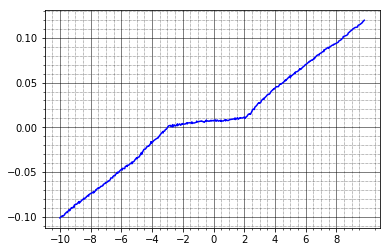

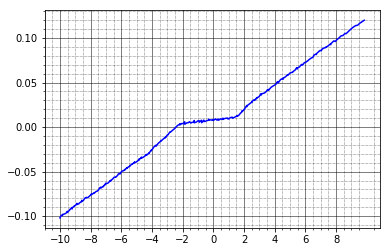

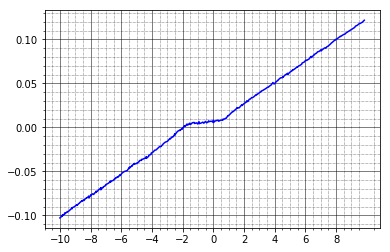

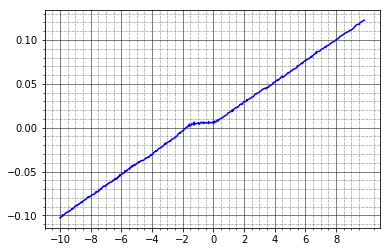

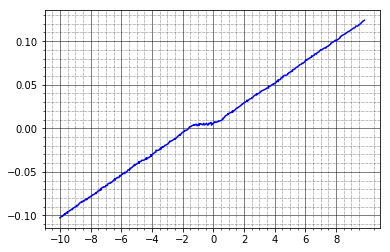

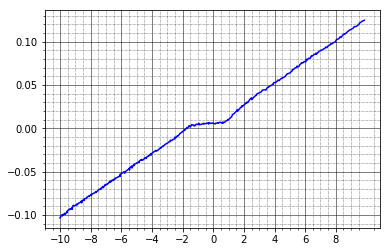

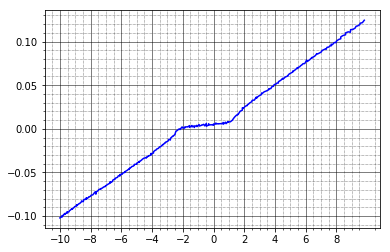

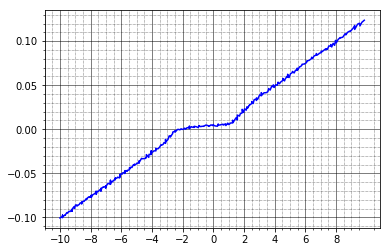

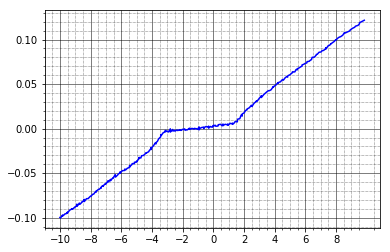

In [13]:
for sheet_idx in range(len(mod_no_linear_trend_list)):
    fig, ax = plt.subplots()
    print('Sheet index = {}'.format(sheet_idx))
    chan_1_no_lin, chan_2_no_lin = zip(*mod_no_linear_trend_list[sheet_idx][0])
    chan_1, chan_2 = zip(*mod_DataSheets[sheet_idx].combined_set)

    # Plot the original data
    ax.plot(chan_1, chan_2, color='blue')
    
    # Don't allow the axis to be on top of your data
    ax.set_axisbelow(True)
    
    ax.set_xticks(range(-10, 10, 2))

    # Turn on the minor TICKS, which are required for the minor GRID
    ax.minorticks_on()

    # Customize the major grid
    ax.grid(which='major', linestyle='-', linewidth='0.5', color='black')
    # Customize the minor grid
    ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')

### Trying to fit curve for critical current

In [42]:
def heaviside(x1):
    return 0.5*(np.sign(x1) + 1)

In [43]:
def super_model(x, m_n, m_s, I_c_left, I_c_right):
    return m_n*(x-I_c_left)*(1 - heaviside(x - I_c_left))+m_n*(x-I_c_right)*heaviside(x - I_c_right) + m_s*x*(heaviside(x - I_c_left) - heaviside(x - I_c_right))

Sheet index = 0


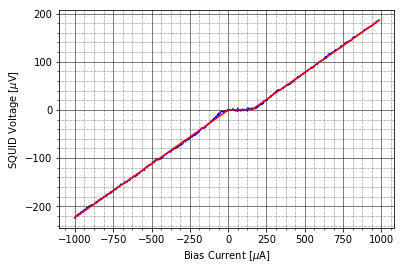

Sheet index = 1


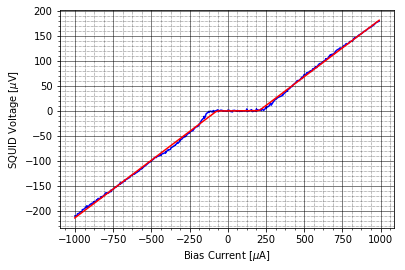

Sheet index = 2


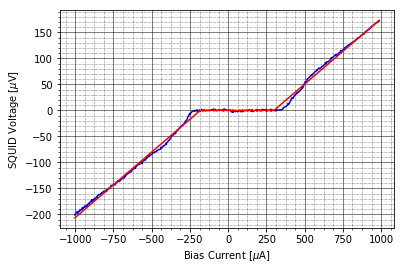

Sheet index = 3


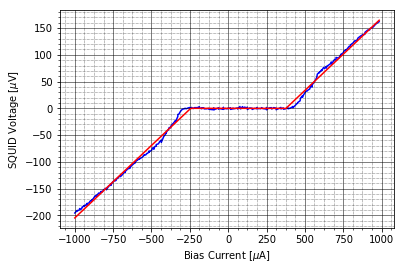

Sheet index = 4


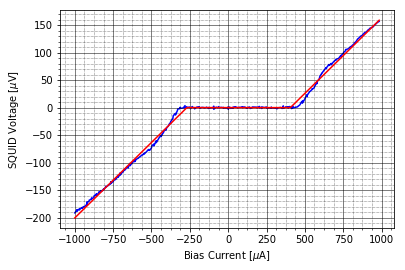

Sheet index = 5


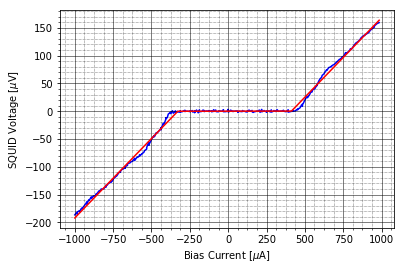

Sheet index = 6


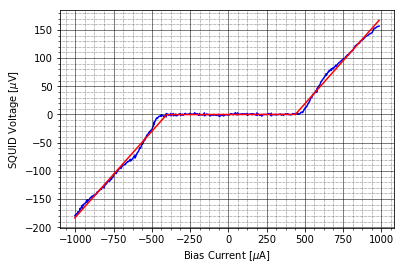

Sheet index = 7


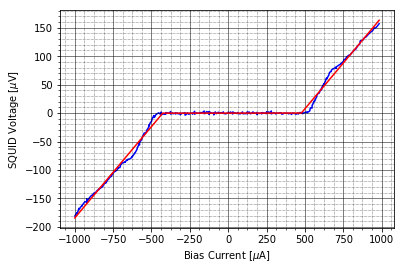

Sheet index = 8


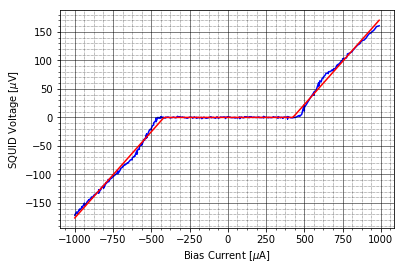

Sheet index = 9


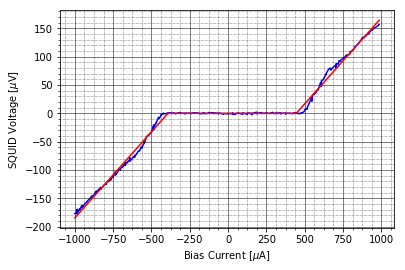

Sheet index = 10


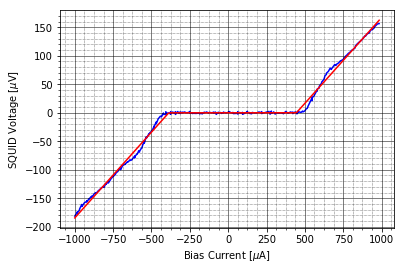

Sheet index = 11


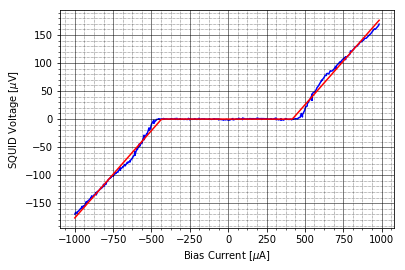

Sheet index = 12


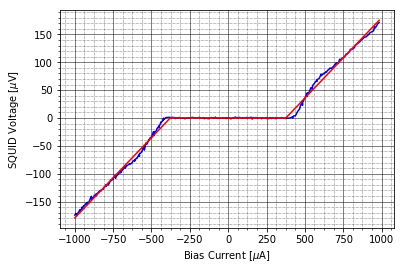

Sheet index = 13


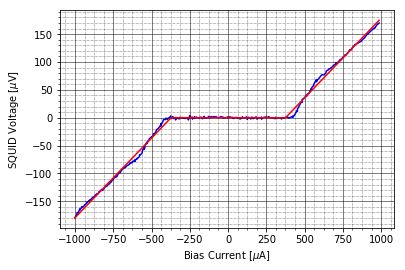

Sheet index = 14


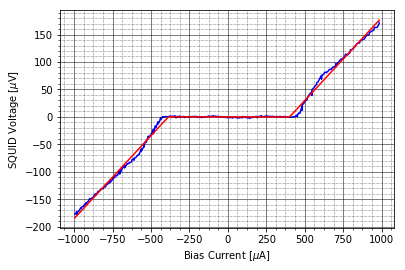

Sheet index = 15


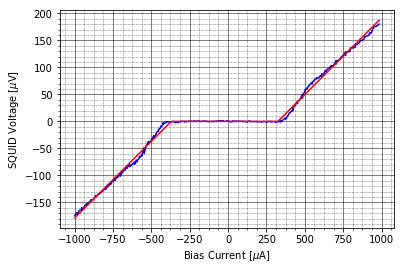

Sheet index = 16


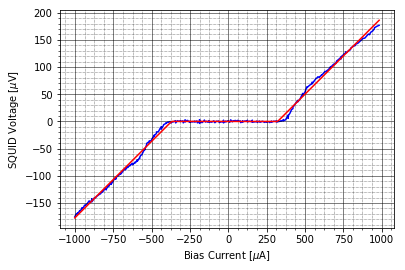

Sheet index = 17


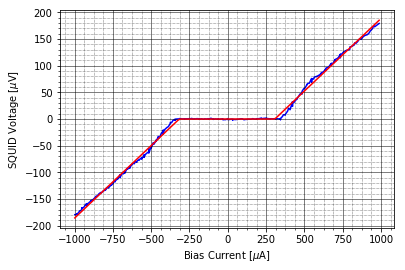

Sheet index = 18


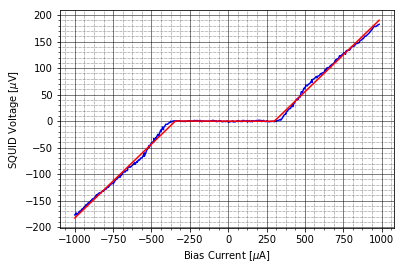

Sheet index = 19


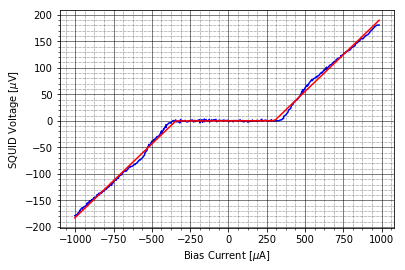

Sheet index = 20


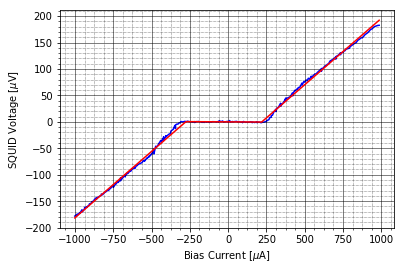

Sheet index = 21


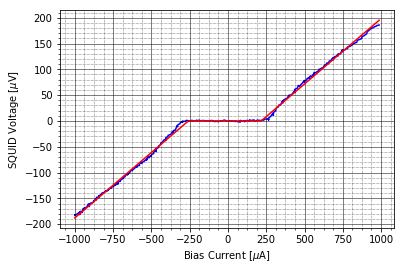

Sheet index = 22


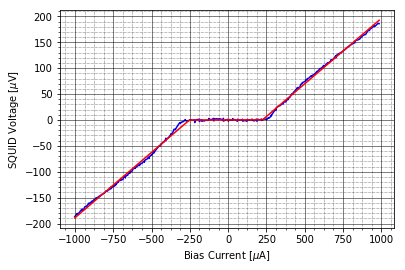

Sheet index = 23


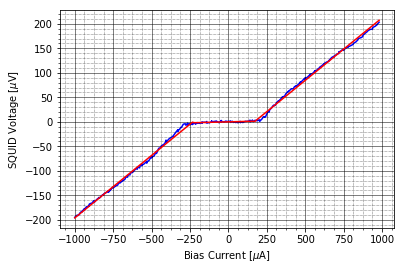

Sheet index = 24


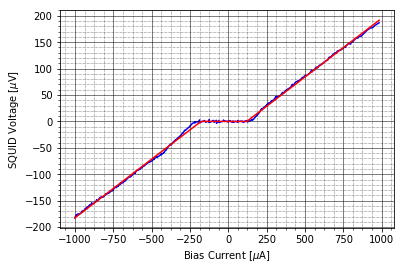

Sheet index = 25


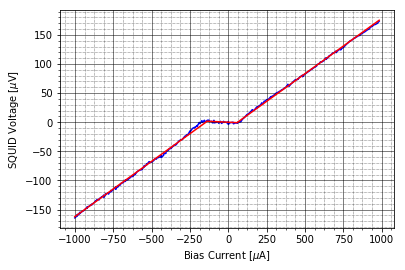

Sheet index = 26


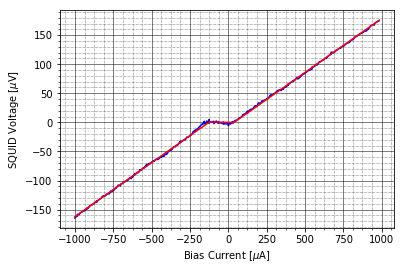

Sheet index = 27


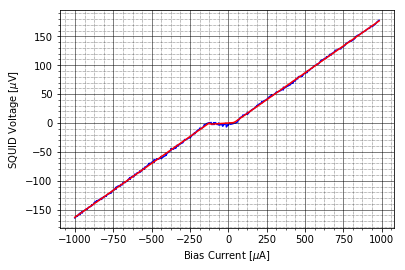

Sheet index = 28


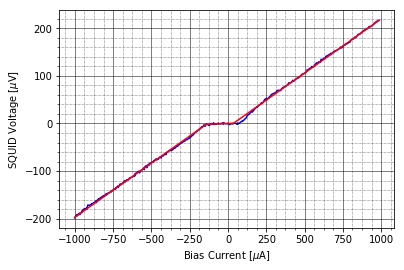

Sheet index = 29


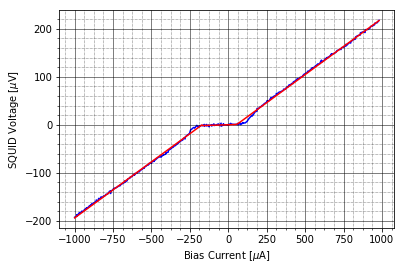

Sheet index = 30


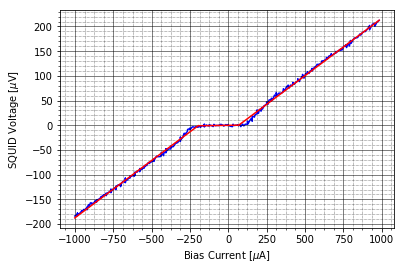

Sheet index = 31


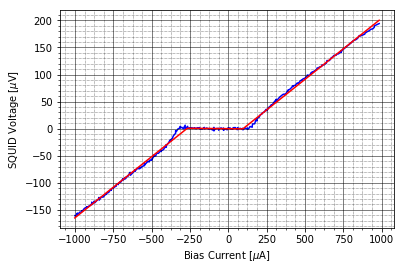

In [44]:
# Fits curves to IV plots (also converts data to correct units)
curve_fits = []
for i,sheet in enumerate(mod_DataSheets):
    
    gain = sheet.setup_params['srs gain']
    resistance = 1e4 #sheet.setup_params['resistance']
    
    print("Sheet index = {}".format(i))
    chan_1, chan_2 = zip(*mod_no_linear_trend_list[i][0])
    
    chan_1 = np.asarray(chan_1)
    chan_2 = np.asarray(chan_2)
    
    # Wait to convert the chan_1 voltage into current until after the fit, so that the fit does alright. 
    # Scaling before causes the fit to suffer from numerical instability
    
    # Scale the output signal down by the gain from the SRS
    chan_2 = chan_2 / gain
    
    loc_1 = loc_array[0, 1]
    loc_2 = loc_array[0, 2]
    
    popt, pcov = curve_fit(super_model, chan_1, chan_2, p0=[0.01, 0.005, (loc_1 + 0.5), (loc_2 - 0.5)])
    
    y = super_model(chan_1, popt[0], popt[1], popt[2], popt[3])
    y = np.asarray(y)
    popt = np.asarray(popt)
     
    fig, ax = plt.subplots()
    
    # Convert to current (in units of uA)
    current = (chan_1 / resistance) * 1e6
    
    popt[0] = popt[0] * resistance
    popt[1] = popt[1] * resistance
    popt[2] = popt[2] / resistance * 1e6 # units of uA
    popt[3] = popt[3] / resistance * 1e6 # untis of uA
    
    pcov[0, 0] = pcov[0, 0] * resistance**2
    pcov[1, 1] = pcov[1, 1] * resistance**2
    pcov[2, 2] = pcov[2, 2] * (1e6 / resistance)**2
    pcov[3, 3] = pcov[3, 3] * (1e6 / resistance)**2
    
    
    chan_2 = chan_2 * 1e6
    y = y * 1e6
    
    ax.plot(current, y, color='red', label='fit', zorder=2)
    ax.plot(current, chan_2, color='blue', label='data', zorder=0)
    
    # Figure housekeeping
    # -------------------
    # Don't allow the axis to be on top of your data
    ax.set_axisbelow(True)
    
    ax.set_xticks(range(-1000, 1250, 250))

    # Turn on the minor TICKS, which are required for the minor GRID
    ax.minorticks_on()

    # Customize the major grid
    ax.grid(which='major', linestyle='-', linewidth='0.5', color='black')
    # Customize the minor grid
    ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    
    ax.set_xlabel(r'Bias Current [$\mu$A]')
    ax.set_ylabel(r'SQUID Voltage [$\mu$V]')
    
    #if i in [0, 4, 13, 32]:
        #fig.savefig('final_figures/curve_fits_{}'.format(str(i).zfill(3)), bbox_inches='tight', dpi=300)
    
    plt.show()
    
    # Calculate residuals to save for later
    residuals = chan_2 - y
    
    fit_tuple = (current, chan_2, residuals, popt, pcov)
    curve_fits.append(fit_tuple)
    
    

### Plots for fit parameters vs I_flux_bias

Mean of m_n = 0.2613696518966768
Standard Dev. of m_n = 0.03688030762188672


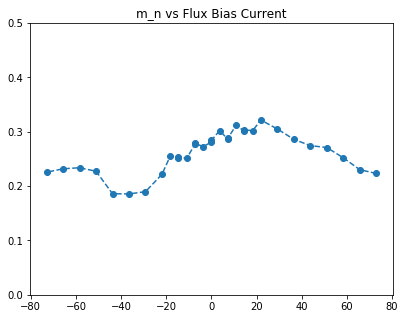

In [39]:
# Plot different parameters with respect to I_flux_bias

fig, ax = plt.subplots(figsize=(6.5, 5))
flux_biases = []
m_normal = []

for sheet,fit in zip(mod_DataSheets, curve_fits):
    
    flux_bias = sheet.setup_params['flux bias current'] * 1e3 # mA
    flux_biases.append(flux_bias)
    
    m_n = fit[3][0]
    m_normal.append(m_n)

ax.set_ylim([0.0, 0.5])
ax.plot(flux_biases, m_normal, 'o--')
ax.set_title('m_n vs Flux Bias Current')

print('Mean of m_n = {}'.format(np.mean(np.asarray(m_normal)))) # Ohms
print('Standard Dev. of m_n = {}'.format(np.sqrt(np.var(np.asarray(m_normal)))))
plt.show()

Mean of m_n = 0.034166180983603495
Standard Dev. of m_n = 0.00865397745011528


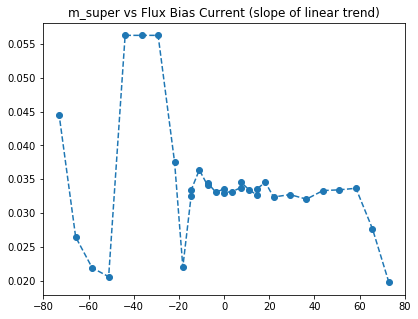

In [89]:
# Plot different parameters with respect to I_flux_bias

fig, ax = plt.subplots(figsize=(6.5, 5))
flux_biases = []

for sheet,fit in zip(mod_DataSheets, curve_fits):
    flux_bias = sheet.setup_params['flux bias current'] * 1e3 # mA
    flux_biases.append(flux_bias)

ax.plot(flux_biases, m_super, 'o--')
ax.set_title('m_super vs Flux Bias Current (slope of linear trend)')

print('Mean of m_n = {}'.format(np.mean(np.asarray(m_super)))) # Ohms
print('Standard Dev. of m_n = {}'.format(np.sqrt(np.var(np.asarray(m_super)))))
plt.show()

In [ ]:
# Plot different parameters with respect to I_flux_bias

fig, ax = plt.subplots(figsize=(6.5, 5))
flux_biases = []
i_c = []

for sheet,fit in zip(mod_DataSheets, curve_fits):
    
    flux_bias = sheet.setup_params['flux bias current'] * 1e3 # mA
    flux_biases.append(flux_bias)
    
    m_n = fit[3][0]
    m_normal.append(m_n)

ax.set_ylim([0.0, 0.5])
ax.plot(flux_biases, m_normal, 'o--')
ax.set_title('m_n vs Flux Bias Current')

print('Mean of m_n = {}'.format(np.mean(np.asarray(m_normal))))
print('Standard Dev. of m_n = {}'.format(np.sqrt(np.var(np.asarray(m_normal)))))
plt.show()

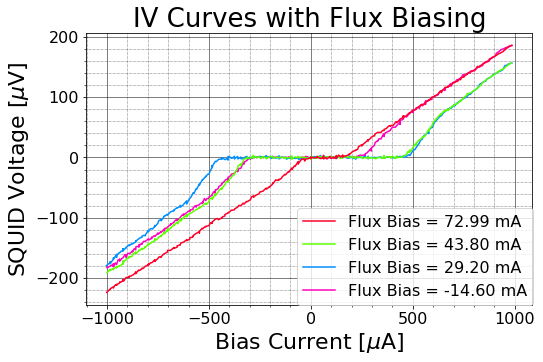

In [18]:
# Plots for Alex
alex_sheet = [mod_DataSheets[0], mod_DataSheets[4], mod_DataSheets[6], mod_DataSheets[21]]
alex_no_lin = [mod_no_linear_trend_list[0], mod_no_linear_trend_list[4], mod_no_linear_trend_list[6], 
               mod_no_linear_trend_list[21]]

color_idx = np.linspace(0.0, 1.0, len(alex_sheet))
fig, ax = plt.subplots(figsize=(8, 5))
i = 0

for color,sheet in zip(color_idx, alex_sheet):
    
    gain = sheet.setup_params['srs gain']
    resistance = 1e4
    
    flux_bias = sheet.setup_params['flux bias current'] * 1e3
    
    chan_1, chan_2 = zip(*alex_no_lin[i][0])
    
    chan_1 = np.asarray(chan_1)
    chan_2 = np.asarray(chan_2)
    
    # Scale the output signal down by the gain from the SRS
    chan_2 = (chan_2 / gain) * 1e6
    
    # Convert to correct units
    current = (chan_1 / resistance) * 1e6
    
    ax.plot(current, chan_2, color = plt.cm.gist_rainbow(color), label='Flux Bias = {0:.2f} mA'.format(flux_bias), zorder=10-i)
    
    # Figure housekeeping
    # -------------------
    # Don't allow the axis to be on top of your data
    ax.set_axisbelow(True)
    
    ax.set_xticks(range(-1000, 1001, 500))

    # Turn on the minor TICKS, which are required for the minor GRID
    ax.minorticks_on()

    # Customize the major grid
    ax.grid(which='major', linestyle='-', linewidth='0.5', color='black')
    # Customize the minor grid
    ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    
    i += 1
    
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlabel(r'Bias Current [$\mu$A]', fontsize=22)
ax.set_ylabel(r'SQUID Voltage [$\mu$V]', fontsize=22)

ax.legend(bbox_to_anchor=(1.02, -0.03), prop={'size':16}, loc=4, fancybox=True)

ax.set_title("IV Curves with Flux Biasing", fontsize=26)

#fig.savefig('final_figures/iv_flux_bias.png', bbox_inches='tight', dpi=300)
plt.show()

In [45]:
def sinc_model(x, offset, amp, A):
    return np.abs(amp*np.sinc((x - offset)/A))

Sinc Model fit params: 
Offset = 21.363930127635687
Amplitude = 434.87409566328
Periodicity = 62.06667256980155
Standard Dev. of Periodicity = 1.4154492779855623


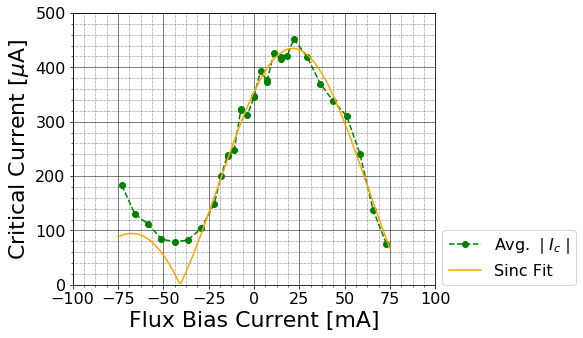

In [58]:
# Plot the critical currents with respect to Flux Bias Current

# Axes are: x -> Flux Bias current (mA)
#           y -> Critical current  (uA)
bias_currents = []
I_c_plus = []
I_c_minus = []
err_minus = []
err_plus = []

fig, ax = plt.subplots(figsize=(6.5,5))

for fit,sheet in zip(curve_fits, mod_DataSheets):
    
    bias_current_curr = sheet.setup_params['flux bias current'] * 1e3
    bias_current = bias_currents.append(bias_current_curr) # Plot bias currents in mA
    I_c_plus_curr = fit[3][3]
    I_c_minus_curr = fit[3][2]
    
    plus_err_curr = np.sqrt(fit[4][3, 3])
    minus_err_curr = np.sqrt(fit[4][2, 2])
    
    I_c_plus.append(I_c_plus_curr)
    I_c_minus.append(I_c_minus_curr)
    err_minus.append(minus_err_curr)
    err_plus.append(plus_err_curr)
    
#     ax.errorbar(bias_current_curr, I_c_plus_curr, yerr=plus_err_curr, markersize=50.0, capsize=2.0, color='red')
#     ax.errorbar(bias_current_curr, I_c_minus_curr, yerr=minus_err_curr, markersize=50.0, capsize=2.0, color='blue')

I_c_plus = np.asarray(I_c_plus)
I_c_minus = np.asarray(I_c_minus)
# ax.plot(bias_currents, I_c_plus, 'o--', color='red', label=r'$I_{c+}$')
# ax.plot(bias_currents, (I_c_plus + I_c_minus)/2, 'o--', color='purple', label=r'Avg. $I_c$')
# ax.plot(bias_currents, I_c_minus, 'o--', color='blue', label=r'$I_{c-}$')


# Try to fit sinc_model to the modulation data
ax.plot(bias_currents, (I_c_plus - I_c_minus)/2, 'o--', color='green', label=r'Avg. $\mid I_c \mid$')
popt, pcov = curve_fit(sinc_model, bias_currents, (I_c_plus - I_c_minus)/2, p0=[21.0, 430.0, 62.0])

# Plot the curve fit
x = np.linspace(-75, 75, 200)
ax.plot(x, sinc_model(x, popt[0], popt[1], popt[2]), color='orange', label='Sinc Fit')
print('Sinc Model fit params: \nOffset = {}\nAmplitude = {}\nPeriodicity = {}'.format(popt[0], popt[1], popt[2]))
print('Standard Dev. of Periodicity = {}'.format(np.sqrt(pcov[2, 2])))

# Figure housekeeping
# --------------------------------------
ax.set_ylim([0, 500])
#ax.set_ylim([-500, 500])

# Don't allow the axis to be on top of your data
ax.set_axisbelow(True)

ax.set_xticks(range(-100, 101, 25))
ax.set_xlim([-100, 100])

# Turn on the minor TICKS, which are required for the minor GRID
ax.minorticks_on()

# Customize the major grid
ax.grid(which='major', linestyle='-', linewidth='0.5', color='black')
# Customize the minor grid
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')

ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlabel(r'Flux Bias Current [mA]', fontsize=22)
ax.set_ylabel(r'Critical Current [$\mu$A]', fontsize=22)

ax.legend(bbox_to_anchor=(1.41, -0.03), prop={'size':16}, loc=4, fancybox=True)

#ax.set_title(r'$I_c$ Modulation', fontsize=26)

fig.savefig('final_figures/paper_figures/I_c_modulation_with_sinc_fit_abs.png', bbox_inches='tight', dpi=300)
plt.show()

Sheet index = 0


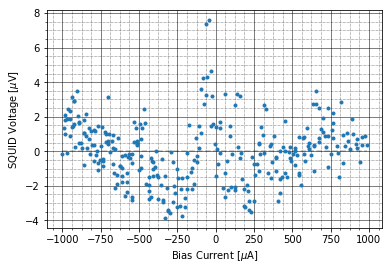

Sheet index = 1


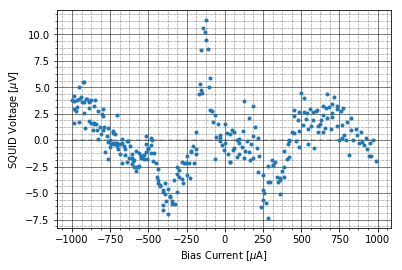

Sheet index = 2


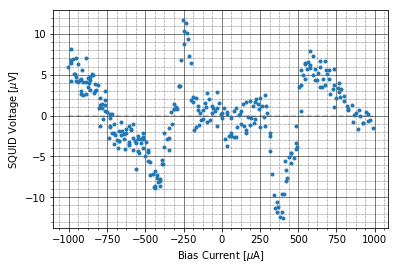

Sheet index = 3


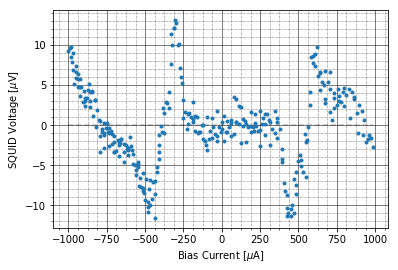

Sheet index = 4


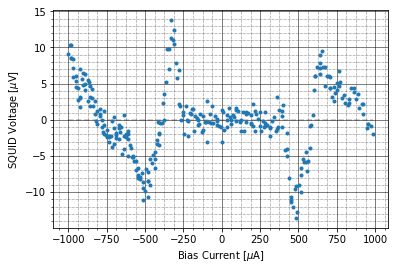

Sheet index = 5


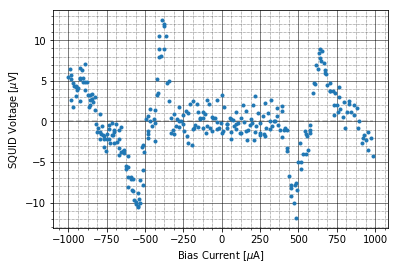

Sheet index = 6


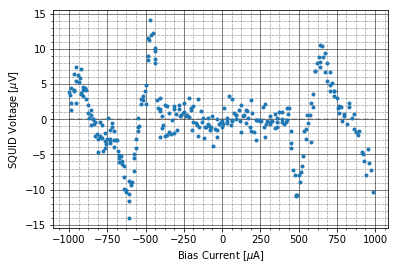

Sheet index = 7


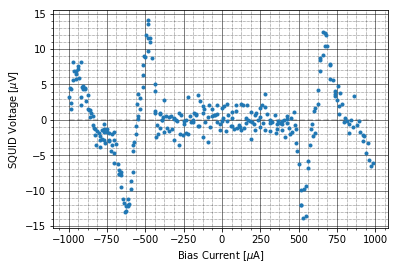

Sheet index = 8


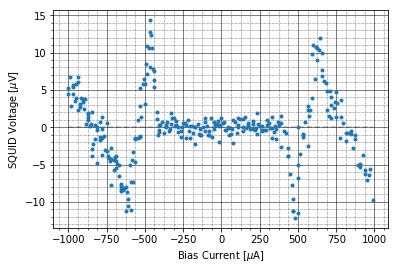

Sheet index = 9


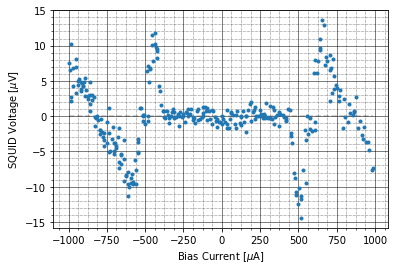

Sheet index = 10


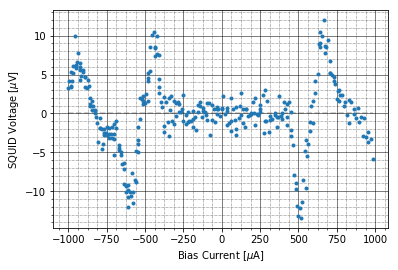

Sheet index = 11


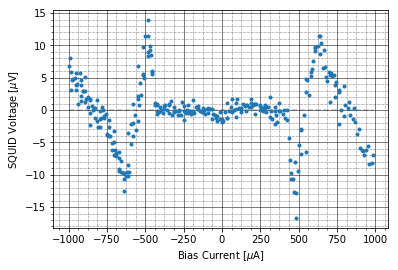

Sheet index = 12


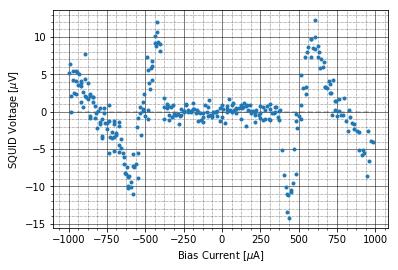

Sheet index = 13


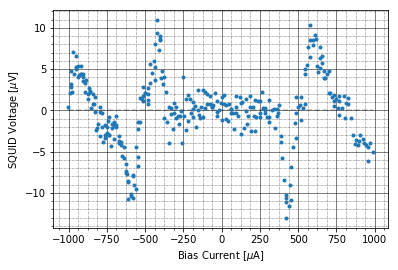

Sheet index = 14


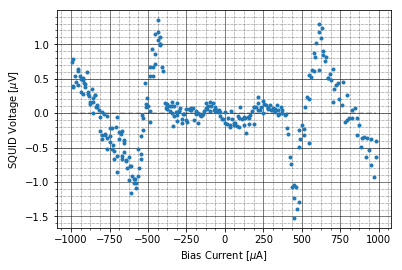

Sheet index = 15


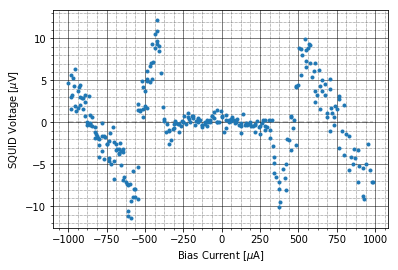

Sheet index = 16


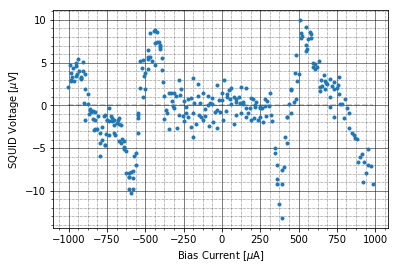

Sheet index = 17


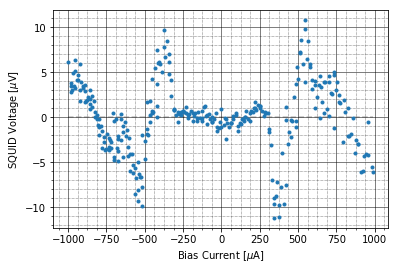

Sheet index = 18


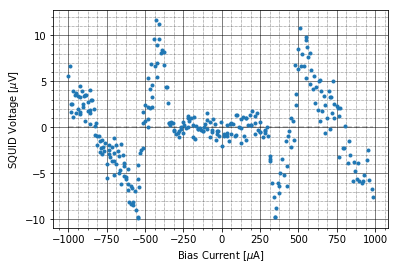

Sheet index = 19


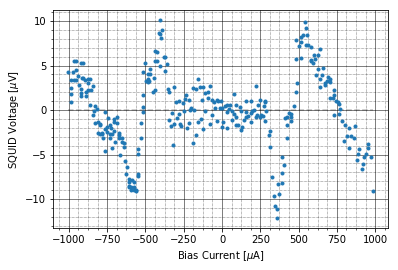

Sheet index = 20


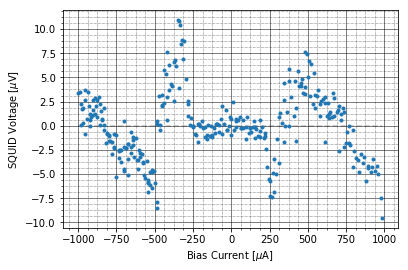

Sheet index = 21


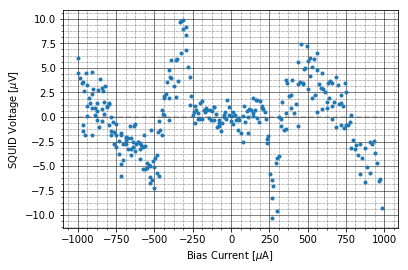

Sheet index = 22


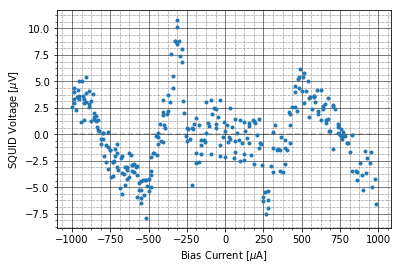

Sheet index = 23


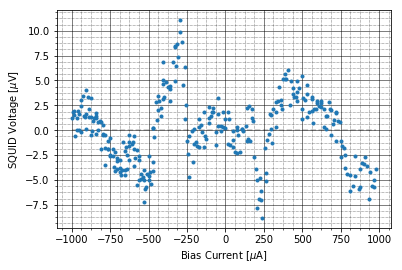

Sheet index = 24


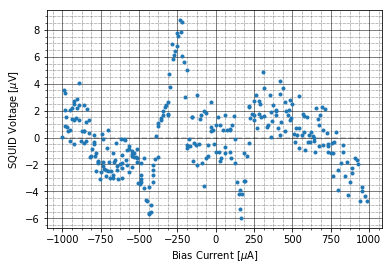

Sheet index = 25


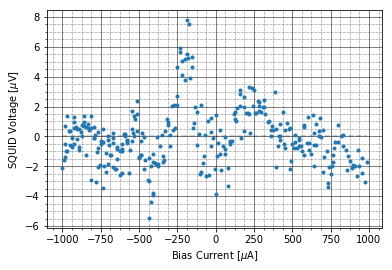

Sheet index = 26


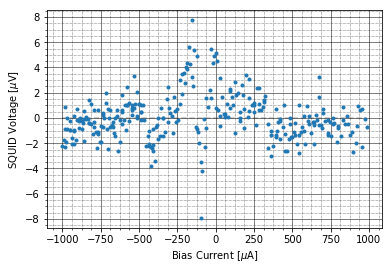

Sheet index = 27


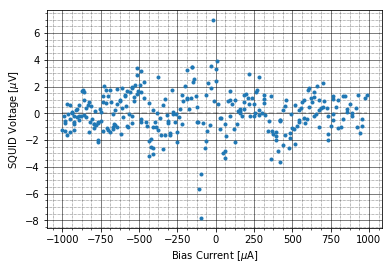

Sheet index = 28


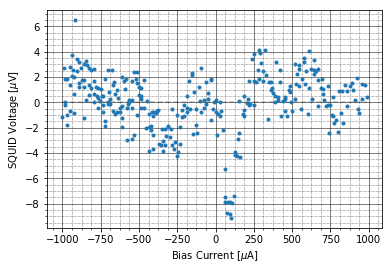

Sheet index = 29


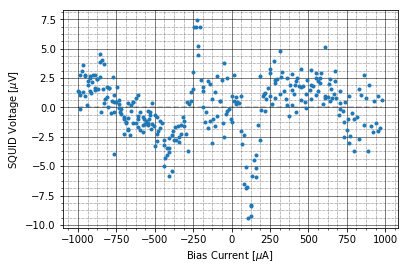

Sheet index = 30


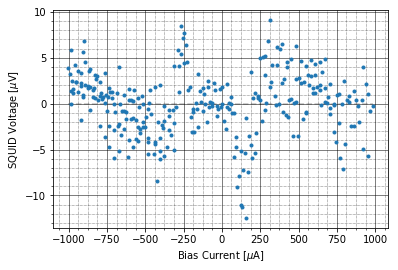

Sheet index = 31


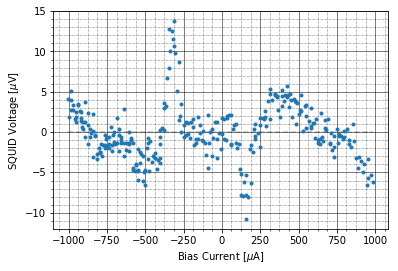

In [114]:
# Plot the residuals
for i,fit in enumerate(curve_fits):
    
    print("Sheet index = {}".format(i))
    
    fig, ax = plt.subplots()
    
    current = fit[0]
    residuals = fit[2]
    
    ax.plot(current, residuals, '.')
    
    x = np.linspace(min(current), max(current), 100)
    ax.plot(x, np.zeros(len(x)), '--', alpha=0.5, zorder=0, color='gray')
    ax.set_xlabel(r'Bias Current [$\mu$A]')
    ax.set_ylabel(r'SQUID Voltage [$\mu$V]')
    
    # Turn on the minor TICKS, which are required for the minor GRID
    ax.minorticks_on()

    # Customize the major grid
    ax.grid(which='major', linestyle='-', linewidth='0.5', color='black')
    # Customize the minor grid
    ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    
    if i==4:
        fig.savefig('final_figures/fit_residuals_{}'.format(str(i).zfill(3), bbox_inches='tight', dpi=300))
    
    plt.show()

Sheet index = 0


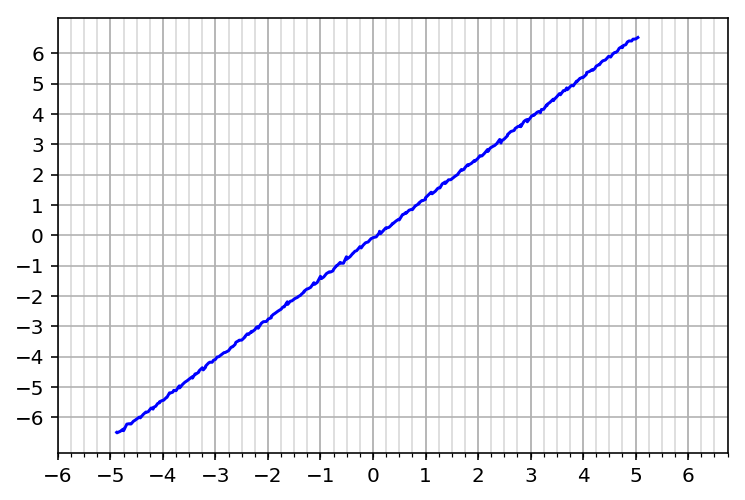

Sheet index = 1


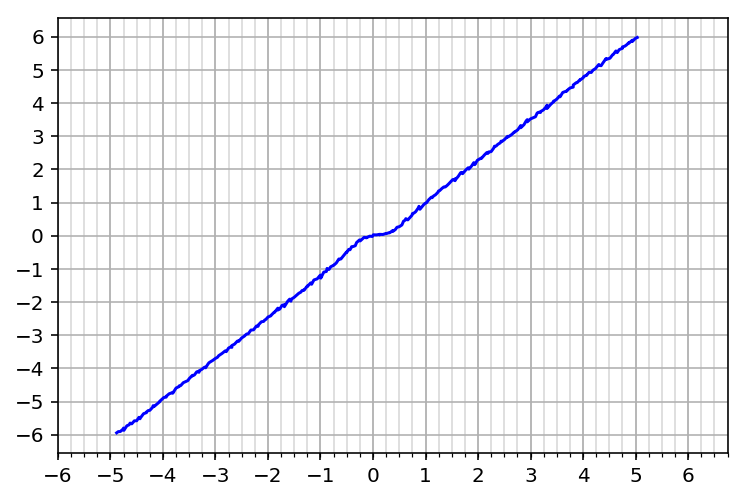

Sheet index = 2


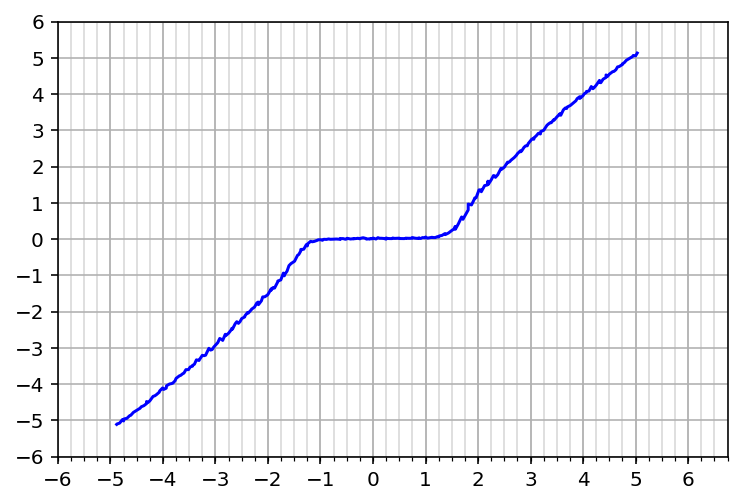

Sheet index = 3


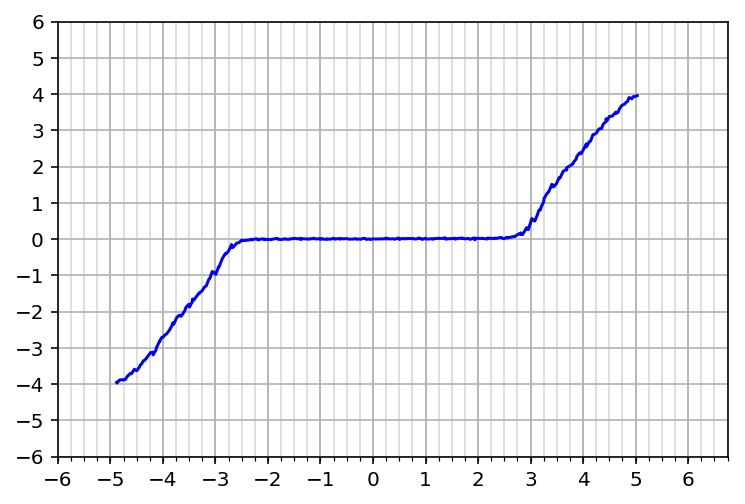

Sheet index = 4


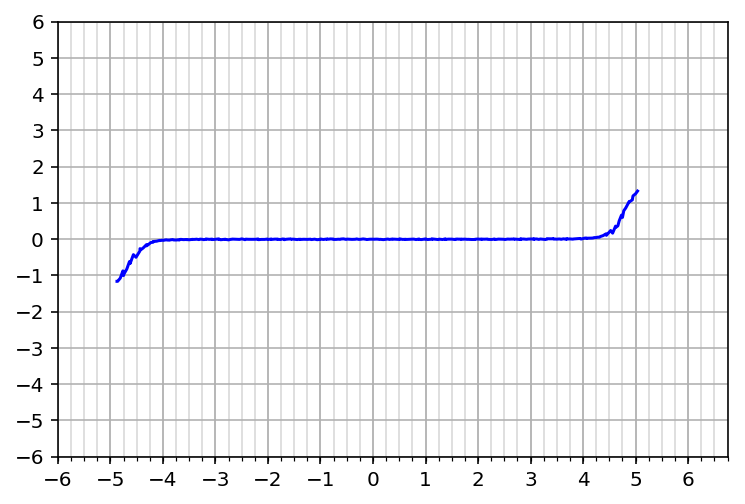

Sheet index = 5


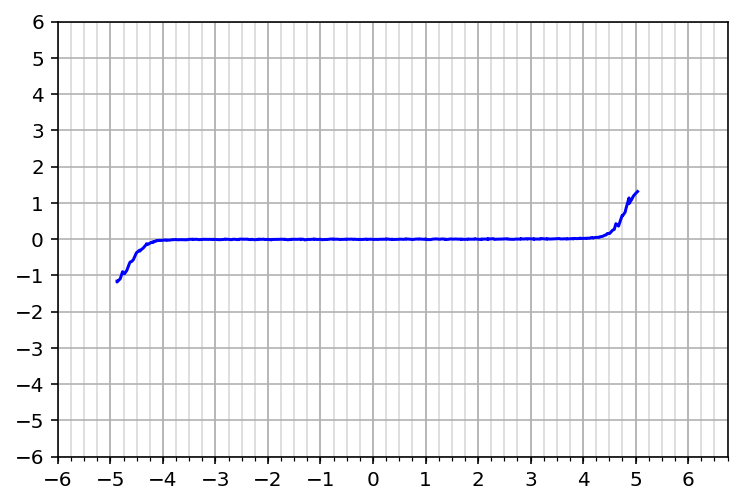

Sheet index = 6


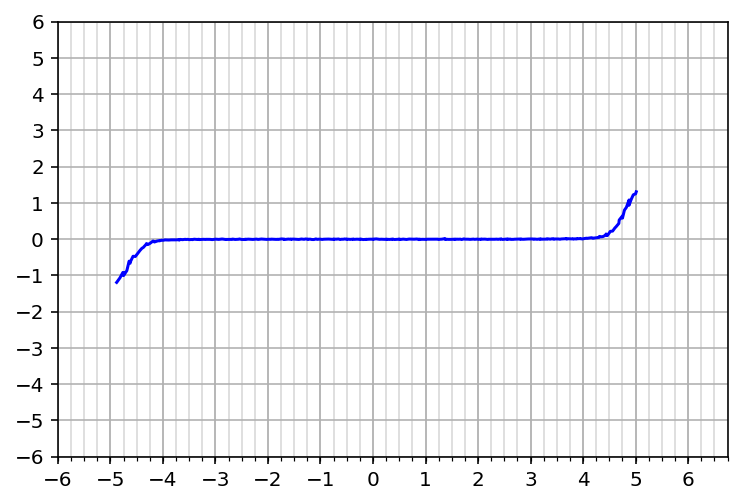

Sheet index = 7


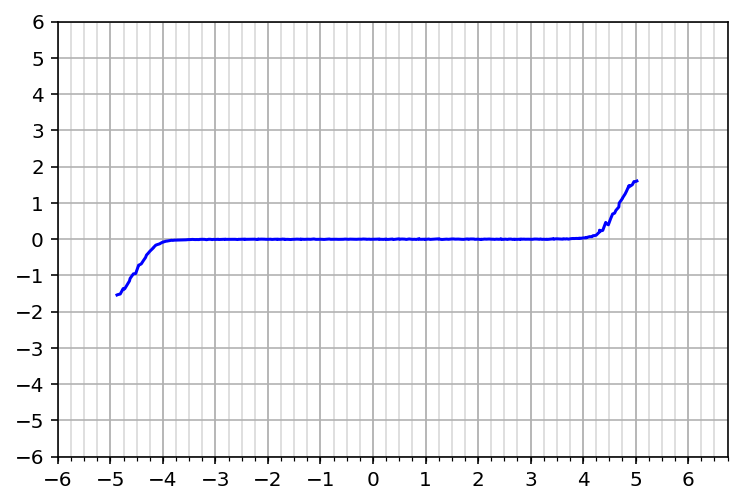

In [126]:
for sheet_idx in range(len(temp_DataSheets)):
    fig, ax = plt.subplots()
    print('Sheet index = {}'.format(sheet_idx))
    chan_1, chan_2 = zip(*temp_DataSheets[sheet_idx].combined_set)

    # Plot the original data
    ax.plot(chan_1, chan_2, color='blue')
    
    # Don't allow the axis to be on top of your data
    ax.set_axisbelow(True)
    
    ax.set_xticks(range(-6, 8, 2))

    # Turn on the minor TICKS, which are required for the minor GRID
    #ax.minorticks_on()

    # Major ticks every 2, minor ticks every 0.25
    major_ticks = np.arange(-6, 7, 1)
    minor_ticks = np.arange(-6, 7, 0.25)

    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_yticks(major_ticks)
    #ax.set_yticks(minor_ticks, minor=True)

    # And a corresponding grid
    ax.grid(which='both')
    
    ax.grid(which='minor', alpha=0.5)
    ax.grid(which='major', alpha=1.0)
    
    plt.show()

In [12]:
temp_loc_array = np.array([[0, 0, 0], [1, -0.15, 0.25], [2, -1.23, 1.25], [3, -2.5, 2.75], [4, -4.24, 4.27], [5, -4.15, 4.35], 
                          [6, -4.20, 4.30], [7, -4.0, 4.25]])

In [13]:
import matplotlib.cm as cm
#%config InlineBackend.figure_format = 'retina'

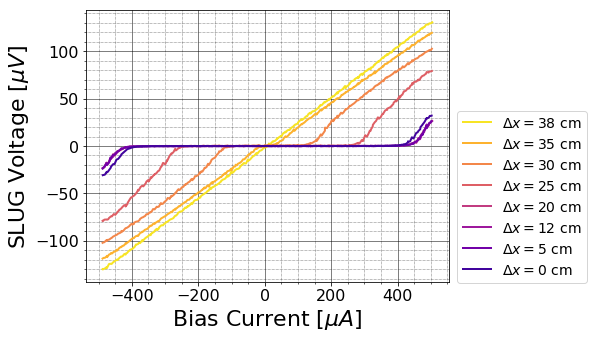

In [79]:
# Temperature series plot

color_idx = reversed(np.linspace(0.1, 0.95, len(temp_DataSheets)))

fig, ax = plt.subplots(figsize=(6.5,5))

plot_labels = []
for sheet in temp_DataSheets:
    plot_labels.append(r'$\Delta x = ${} cm'.format(int(sheet.setup_params['distance'] * 100)))

i = 0
for color,sheet in zip(color_idx, temp_DataSheets):
    
    gain = sheet.setup_params['srs gain']
    resistance = 1e4
    
    chan_1, chan_2 = zip(*sheet.combined_set)
    
    chan_1 = np.asarray(chan_1)
    chan_2 = np.asarray(chan_2)
    
    # Convert the chan_1 voltage to current and set it to be in units of uA
    current = (chan_1 / resistance) * 1e6
    # Scale the output signal down by the gain from the SRS set it to be in units of uV
    chan_2 = (chan_2 / gain) * 1e6
    
    # Color maps to try: plasma, magma, inferno, viridis, hot, CMRmap
    ax.plot(current, chan_2, color = plt.cm.plasma(color), linewidth=2.0, label=plot_labels[i])
    
    # Don't allow the axis to be on top of your data
    ax.set_axisbelow(True)
    
    ax.set_xticks([-400, -200, 0, 200, 400])

    # Turn on the minor TICKS, which are required for the minor GRID
    ax.minorticks_on()

    # Customize the major grid
    ax.grid(which='major', linestyle='-', linewidth='0.5', color='black', )
    # Customize the minor grid
    ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_xlabel(r'Bias Current [$\mu A$]', fontsize=22)
    ax.set_ylabel(r'SLUG Voltage [$\mu V$]', fontsize=22)
    
    ax.legend(bbox_to_anchor=(1.4, -0.03), prop={'size':14}, loc=4, fancybox=True)
    
    #ax.set_title('SLUG Temperature Series', fontsize=26)
    
    i += 1

fig.savefig('slug_temperature_series_no_title.png', bbox_inches='tight', dpi=300)
plt.show()

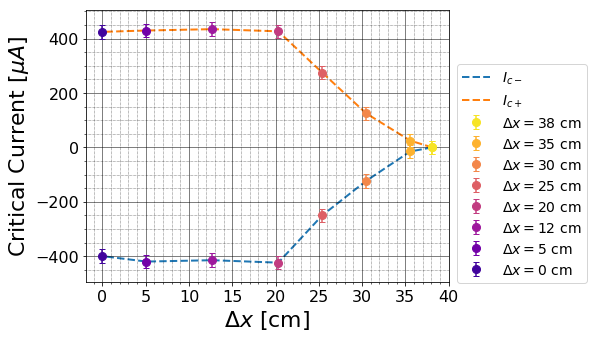

In [14]:
distances = []
I_c_plus = []
I_c_minus = []

fig, ax = plt.subplots(figsize=(6.5,5))
i = 0
resistance = 1e4
yerr = (0.25/ resistance) * 1e6

color_idx = reversed(np.linspace(0.1, 0.95, len(temp_DataSheets)))

plot_labels = []
for sheet in temp_DataSheets:
    plot_labels.append(r'$\Delta x = ${} cm'.format(int(sheet.setup_params['distance'] * 100)))

for color,sheet in zip(color_idx, temp_DataSheets):
    
    resistance = 1e4
    
    # Put critical current in units of uA
    I_c_plus_curr = (temp_loc_array[i][1] / resistance) * 1e6
    I_c_minus_curr = (temp_loc_array[i][2] / resistance) * 1e6
    
    # Put distance in cm
    distance_curr = sheet.setup_params['distance'] * 1e2
    
    I_c_plus.append(I_c_plus_curr)
    I_c_minus.append(I_c_minus_curr)
    distances.append(distance_curr)
    
    ax.errorbar(distance_curr, I_c_plus_curr, yerr=yerr, fmt='o', color = plt.cm.plasma(color), label=plot_labels[i], 
                markersize=8.0, capsize=3.0)
    ax.errorbar(distance_curr, I_c_minus_curr, yerr=yerr, fmt='o', color = plt.cm.plasma(color), markersize=8.0, 
               capsize=3.0)
    i += 1

ax.plot(distances, I_c_plus, '--', zorder = 0, label=r'$I_{c-}$', linewidth=2.0)
ax.plot(distances, I_c_minus, '--', zorder = 0, label=r'$I_{c+}$', linewidth=2.0)


# Don't allow the axis to be on top of your data
ax.set_axisbelow(True)

ax.set_xticks(range(0, 41, 5))

# Turn on the minor TICKS, which are required for the minor GRID
ax.minorticks_on()

# Customize the major grid
ax.grid(which='major', linestyle='-', linewidth='0.5', color='black', )
# Customize the minor grid
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')

ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlabel(r'$\Delta x$ [cm]', fontsize=22)
ax.set_ylabel(r'Critical Current [$\mu A$]', fontsize=22)

ax.legend(bbox_to_anchor=(1.40, -0.03), prop={'size':14}, loc=4, fancybox=True)

#ax.set_title(r'$I_c$ Temperatrue Dependence', fontsize=24)

fig.savefig('i_c_temp_dependence_no_title.png', bbox_inches='tight', dpi=300)
plt.show()

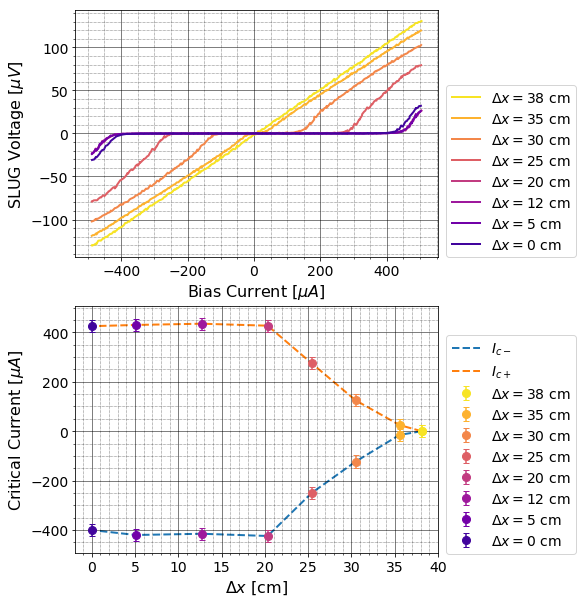

In [27]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6.5, 10))

color_idx = reversed(np.linspace(0.1, 0.95, len(temp_DataSheets)))


# Plot temp IV curves
plot_labels = []
for sheet in temp_DataSheets:
    plot_labels.append(r'$\Delta x = ${} cm'.format(int(sheet.setup_params['distance'] * 100)))

i = 0
for color,sheet in zip(color_idx, temp_DataSheets):
    
    gain = sheet.setup_params['srs gain']
    resistance = 1e4
    
    chan_1, chan_2 = zip(*sheet.combined_set)
    
    chan_1 = np.asarray(chan_1)
    chan_2 = np.asarray(chan_2)
    
    # Convert the chan_1 voltage to current and set it to be in units of uA
    current = (chan_1 / resistance) * 1e6
    # Scale the output signal down by the gain from the SRS set it to be in units of uV
    chan_2 = (chan_2 / gain) * 1e6
    
    # Color maps to try: plasma, magma, inferno, viridis, hot, CMRmap
    ax1.plot(current, chan_2, color = plt.cm.plasma(color), linewidth=2.0, label=plot_labels[i])
    
    # Don't allow the axis to be on top of your data
    ax1.set_axisbelow(True)
    
    ax1.set_xticks([-400, -200, 0, 200, 400])

    # Turn on the minor TICKS, which are required for the minor GRID
    ax1.minorticks_on()

    # Customize the major grid
    ax1.grid(which='major', linestyle='-', linewidth='0.5', color='black', )
    # Customize the minor grid
    ax1.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.set_xlabel(r'Bias Current [$\mu A$]', fontsize=16)
    ax1.set_ylabel(r'SLUG Voltage [$\mu V$]', fontsize=16)
    
    ax1.legend(bbox_to_anchor=(1.4, -0.03), prop={'size':14}, loc=4, fancybox=True)
    
    i += 1
    
# Plot Critical current vs Distance
# --------------------------------

distances = []
I_c_plus = []
I_c_minus = []

i = 0
resistance = 1e4
yerr = (0.25/ resistance) * 1e6

color_idx = reversed(np.linspace(0.1, 0.95, len(temp_DataSheets)))

plot_labels = []
for sheet in temp_DataSheets:
    plot_labels.append(r'$\Delta x = ${} cm'.format(int(sheet.setup_params['distance'] * 100)))

for color,sheet in zip(color_idx, temp_DataSheets):
    
    resistance = 1e4
    
    # Put critical current in units of uA
    I_c_plus_curr = (temp_loc_array[i][1] / resistance) * 1e6
    I_c_minus_curr = (temp_loc_array[i][2] / resistance) * 1e6
    
    # Put distance in cm
    distance_curr = sheet.setup_params['distance'] * 1e2
    
    I_c_plus.append(I_c_plus_curr)
    I_c_minus.append(I_c_minus_curr)
    distances.append(distance_curr)
    
    ax2.errorbar(distance_curr, I_c_plus_curr, yerr=yerr, fmt='o', color = plt.cm.plasma(color), label=plot_labels[i], 
                markersize=8.0, capsize=3.0)
    ax2.errorbar(distance_curr, I_c_minus_curr, yerr=yerr, fmt='o', color = plt.cm.plasma(color), markersize=8.0, 
               capsize=3.0)
    i += 1

ax2.plot(distances, I_c_plus, '--', zorder = 0, label=r'$I_{c-}$', linewidth=2.0)
ax2.plot(distances, I_c_minus, '--', zorder = 0, label=r'$I_{c+}$', linewidth=2.0)


# Don't allow the axis to be on top of your data
ax2.set_axisbelow(True)

ax2.set_xticks(range(0, 41, 5))

# Turn on the minor TICKS, which are required for the minor GRID
ax2.minorticks_on()

# Customize the major grid
ax2.grid(which='major', linestyle='-', linewidth='0.5', color='black', )
# Customize the minor grid
ax2.grid(which='minor', linestyle=':', linewidth='0.5', color='black')

ax2.tick_params(axis='both', which='major', labelsize=14)
ax2.set_xlabel(r'$\Delta x$ [cm]', fontsize=16)
ax2.set_ylabel(r'Critical Current [$\mu A$]', fontsize=16)

ax2.legend(bbox_to_anchor=(1.40, -0.03), prop={'size':14}, loc=4, fancybox=True)

fig.savefig('temp_series_combined_figure.png', bbox_inches='tight', dpi=300)
plt.show()

Sheet index = 0


/Users/josephmurphy/anaconda/lib/python3.5/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


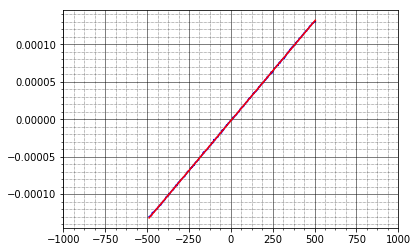

Sheet index = 1


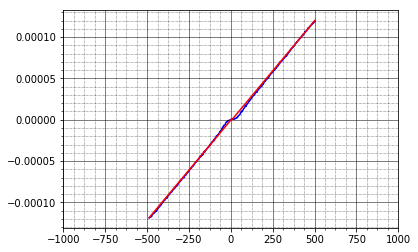

Sheet index = 2


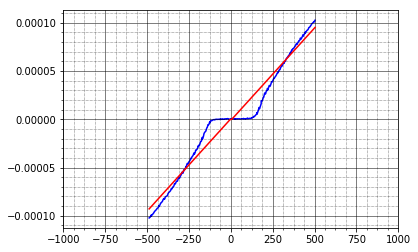

Sheet index = 3


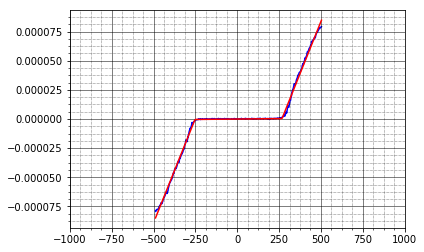

Sheet index = 4


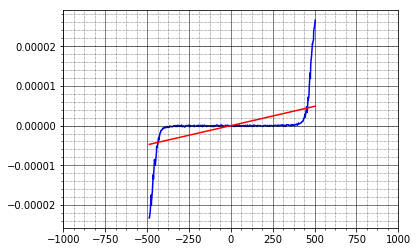

Sheet index = 5


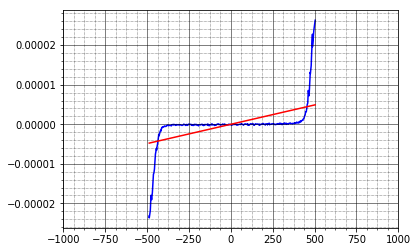

Sheet index = 6


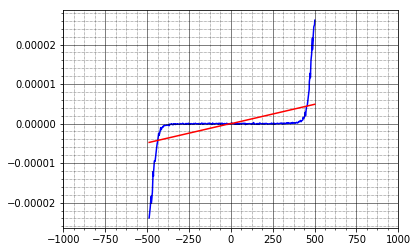

Sheet index = 7


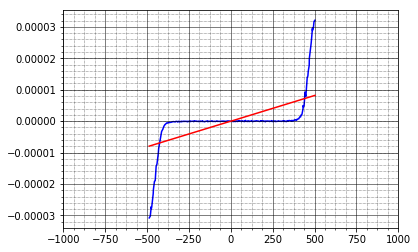

In [27]:
# Fits curves to IV plots (also converts data to correct units)
temp_curve_fits = []
for i,sheet in enumerate(temp_DataSheets):
    
    gain = sheet.setup_params['srs gain']
    resistance = 1e4 #sheet.setup_params['resistance']
    
    print("Sheet index = {}".format(i))
    chan_1, chan_2 = zip(*sheet.combined_set)
    
    chan_1 = np.asarray(chan_1)
    chan_2 = np.asarray(chan_2)
    
    # Wait to convert the chan_1 voltage into current until after the fit, so that the fit does alright. 
    # Scaling before causes the fit to suffer from numerical instability
    
    # Scale the output signal down by the gain from the SRS
    chan_2 = chan_2 / gain
    
    loc_1 = temp_loc_array[0, 1]
    loc_2 = temp_loc_array[0, 2]
    
    popt, pcov = curve_fit(super_model, chan_1, chan_2, p0=[0.01, 0.005, loc_1, loc_2])
    
    y = super_model(chan_1, popt[0], popt[1], popt[2], popt[3])
    y = np.asarray(y)
    popt = np.asarray(popt)
    
    
    fig, ax = plt.subplots()
    
    # Convert to current (in units of uA)
    current = (chan_1 / resistance) * 1e6
    popt = (popt / resistance) * 1e6
    
    ax.plot(current, y, color='red', label='fit', zorder=2)
    ax.plot(current, chan_2, color='blue', label='data', zorder=0)
    
    # Figure housekeeping
    # -------------------
    # Don't allow the axis to be on top of your data
    ax.set_axisbelow(True)
    
    ax.set_xticks(range(-1000, 1250, 250))

    # Turn on the minor TICKS, which are required for the minor GRID
    ax.minorticks_on()

    # Customize the major grid
    ax.grid(which='major', linestyle='-', linewidth='0.5', color='black')
    # Customize the minor grid
    ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    
    
    plt.show()
    
    # Calculate residuals to save for later
    residuals = chan_2 - y
    
    fit_tuple = (current, chan_2, residuals, popt, pcov)
    temp_curve_fits.append(fit_tuple)

## Residual Resistance

In [81]:
resid_mod_DataSheets = []
for j in [8, 9, 11, 12, 15, 17, 18, 20, 21]:
    resid_mod_DataSheets.append(DataSheet(xlsx_modulation, 'modulation', sheet_num = j))

In [151]:
no_resid_mod_DataSheets = []
for j in [0,1,2,3,4,5,6,7,10,13,16,19,22,24,25,26,27,28,29,30,31]:
    no_resid_mod_DataSheets.append(DataSheet(xlsx_modulation, 'modulation', sheet_num=j))

In [149]:
for sheet in no_resid_mod_DataSheets:
    chan_1, chan_2 = list(zip(*sheet.set_1))
    print(np.mean(chan_2))
    sheet.mean_subtract()
    chan_1, chan_2 = list(zip(*sheet.set_1))
    print(np.mean(chan_2))
    print('--------------')

-0.015734721
3.5527136788e-18
--------------
-0.00762744
-2.6645352591e-18
--------------
0.005182908
0.0
--------------
-0.00381372
-1.7763568394e-18
--------------
-0.003644916
-1.33226762955e-18
--------------
-0.002386701
5.3290705182e-18
--------------
0.00051579
-1.7763568394e-18
--------------
-4.8453e-05
1.7763568394e-18
--------------
0.000800256
8.881784197e-19
--------------
-0.002583639
1.7763568394e-18
--------------
-0.000608007
-1.7763568394e-18
--------------
0.001167561
3.5527136788e-18
--------------
-0.000667401
3.5527136788e-18
--------------
-0.002056908
3.5527136788e-18
--------------
-0.002827467
3.5527136788e-18
--------------
-0.002045967
-8.881784197e-19
--------------
-0.002527371
1.7763568394e-18
--------------
-0.002206956
0.0
--------------
-0.001827147
0.0
--------------
-0.000668964
-6.2172489379e-18
--------------
0.00151611
3.5527136788e-18
--------------


In [148]:
for sheet in resid_mod_DataSheets:
    chan_1, chan_2 = list(zip(*sheet.set_1))
    print(np.mean(chan_2))
    sheet.mean_subtract()
    chan_1, chan_2 = list(zip(*sheet.set_1))
    print(np.mean(chan_2))
    print('--------------')

-3.106671524
-6.83897383169e-17
--------------
-4.975021875
1.84741111298e-16
--------------
-3.708071875
-3.69482222595e-16
--------------
-2.477428125
2.34479102801e-16
--------------
-6.143453125
1.52766688188e-15
--------------
-0.016
2.84217094304e-17
--------------
6.029578125
-1.39976918945e-15
--------------
2.4214375
-4.05009359383e-16
--------------
3.63716875
7.1054273576e-17
--------------
4.839884375
4.10338429901e-16
--------------
0.000268836
3.5527136788e-18
--------------


In [82]:
# Combine the three sets for each sheet
for sheet in resid_mod_DataSheets:
    sheet.combine_sets()
    
# for sheet in no_resid_mod_DataSheets:
#     sheet.combine_sets()

Slope = 0.33666796039896735
Uncertainty = 0.0009478668736846785


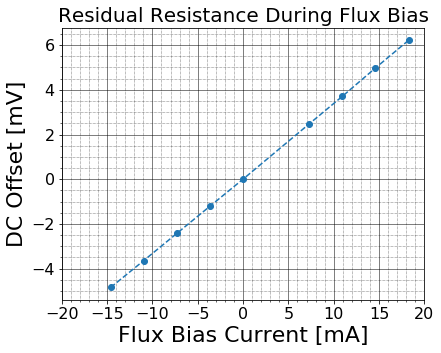

In [85]:
avgs = []
flux_biases = []

fig, ax = plt.subplots(figsize=(6.5, 5))

for sheet in resid_mod_DataSheets:
    
    _, chan_2 = list(zip(*sheet.combined_set))
    
    resistance = 137
    gain = sheet.setup_params['srs gain']
    
    flux_bias = sheet.setup_params['flux bias current'] * 1e3 # mA
    flux_biases.append(flux_bias)
    
    chan_2 = np.asarray(chan_2)
    
    chan_2 = (chan_2 / gain) * 1e3 # mV
    
    chan_2_avg = np.mean(chan_2)
    
    avgs.append(chan_2_avg)
    
ax.plot(flux_biases, -1*np.asarray(avgs), 'o--')

params, cov = np.polyfit(flux_biases, -1*np.asarray(avgs), 1, cov=True)
print('Slope = {}'.format(params[0]))
print('Uncertainty = {}'.format(np.sqrt(cov[0, 0])))

ax.set_axisbelow(True)

ax.set_xticks(range(-20, 21, 5))

# Turn on the minor TICKS, which are required for the minor GRID
ax.minorticks_on()

# Customize the major grid
ax.grid(which='major', linestyle='-', linewidth='0.5', color='black', )
# Customize the minor grid
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')

ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlabel(r'Flux Bias Current [mA]', fontsize=22)
ax.set_ylabel(r'DC Offset [mV]', fontsize=22)

ax.legend(bbox_to_anchor=(1.45, -0.03), prop={'size':14}, loc=4, fancybox=True)

ax.set_title(r'Residual Resistance During Flux Bias', fontsize=20)

# fig.savefig('final_figures/residual_resistance.png', bbox_inches='tight', dpi=300)

plt.show()

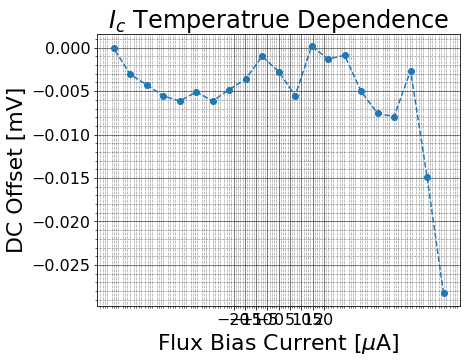

In [155]:
avgs = []
flux_biases = []

fig, ax = plt.subplots(figsize=(6.5, 5))

for sheet in no_resid_mod_DataSheets:
    
    chan_1, chan_2 = zip(*sheet.combined_set)
    
    resistance = 1e4
    gain = sheet.setup_params['srs gain']
    
    flux_bias = sheet.setup_params['flux bias current'] * 1e3
    flux_biases.append(flux_bias)
    
    chan_1 = np.asarray(chan_1)
    chan_2 = np.asarray(chan_2)
    
    chan_2 = (chan_2 / gain) * 1e3 # mV
    
    current = (chan_1 / resistance) * 1e6
    
    chan_2_avg = np.mean(chan_2)
    
    avgs.append(chan_2_avg)
    
ax.plot(flux_biases, avgs, 'o--')

ax.set_axisbelow(True)

ax.set_xticks(range(-20, 21, 5))

# Turn on the minor TICKS, which are required for the minor GRID
ax.minorticks_on()

# Customize the major grid
ax.grid(which='major', linestyle='-', linewidth='0.5', color='black', )
# Customize the minor grid
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')

ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlabel(r'Flux Bias Current [$\mu$A]', fontsize=22)
ax.set_ylabel(r'DC Offset [mV]', fontsize=22)

ax.legend(bbox_to_anchor=(1.45, -0.03), prop={'size':14}, loc=4, fancybox=True)

ax.set_title(r'$I_c$ Temperatrue Dependence', fontsize=24)

#fig.savefig('i_c_temp_dependence.png', bbox_inches='tight', dpi=300)

plt.show()